<a href="https://colab.research.google.com/github/mengyaoo/FNL_GenesSelection/blob/main/10_TC1_Cluster_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the libraries

In [210]:
from __future__ import print_function

import os, sys, gzip, glob, json, time, argparse
import pandas as pd
import numpy as np
import keras
from pandas.io.json import json_normalize

from pandas.io.json import json_normalize
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.manifold as sk_manif
from keras.utils import to_categorical
from google.colab import drive
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation   

In [211]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [212]:
# Read features and output files 
TC1data15 = pd.read_csv("/content/drive/My Drive/FNL_TC1/TC1-S1-data15-genename.tsv", sep="\t", low_memory = False)
#TC1data15 = sfeatures1


In [213]:
outcome = pd.read_csv('/content/drive/My Drive/FNL_TC1/TC1-outcome-data15-projectname.tsv', sep='\t')


In [214]:
TC1data15['project_id_name'] = outcome['Project_id_name']
TC1data15['project_id'] = outcome['Project_id']

In [215]:
TC1data15_cluster = TC1data15.copy()
TC1data15_cluster['project_id_name'] = TC1data15_cluster['project_id_name'].replace(['TCGA-CESC','TCGA-LUSC','TCGA-BLCA','TCGA-HNSC'],'SCC')
TC1data15_cluster['project_id'] = TC1data15_cluster['project_id'].replace([0,2,4,9],0)

cluster_300 = TC1data15_cluster[(TC1data15_cluster['project_id_name'] == 'SCC')].copy().sample(n = 300)
TC1data15_reduced = TC1data15_cluster[(TC1data15_cluster['project_id_name'] != 'SCC')].copy()
TC1data15_reduced = TC1data15_reduced.append(cluster_300)

TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([13],2)
TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([14],4)
TC1data15_reduced['project_id'] = TC1data15_reduced['project_id'].replace([15],9)
TC1data15 = TC1data15_reduced.copy()


In [216]:
TC1data15

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1,project_id_name,project_id
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.0,1.644513,1.765476,2.090856,0.549029,0.718534,0.000000,0.0,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.0,2.098755,1.643610,2.391891,0.884490,0.000000,0.000000,0.0,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.0,1.567345,1.350662,2.029576,0.246144,2.193634,0.000000,0.0,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.0,1.955291,1.635719,2.151499,0.000000,1.956215,0.000000,0.0,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.0,2.429317,1.840638,2.187733,0.238939,1.196076,0.000000,0.0,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3297,1.837379,0.000000,2.007309,0.953466,0.480716,1.309728,0.000000,1.810636,1.298525,1.618744,0.770377,0.888427,1.510074,0.989434,2.514458,0.000000,1.326630,0.054801,1.144359,0.840131,0.0,1.986855,1.423953,1.934423,1.725016,0.392382,0.000000,0.0,1.154091,2.154769,1.405845,0.242554,1.430098,0.000000,0.000000,1.692569,1.008406,0.704560,0.764963,0.929963,...,0.0,

In [217]:
# from keras.utils import to_categorical
outcome = TC1data15.loc[:,['project_id','project_id_name']]
TC1data15 = TC1data15.iloc[:,:-2]

TC1data15.shape, outcome.shape

((3600, 60483), (3600, 2))

In [218]:
def encode(data): 
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [219]:
# outcome = encode(outcome['Project_id'])

# Random Forest

In [220]:
np.random.seed(123)
# define the model
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# fit the model
model.fit(TC1data15, outcome['project_id'])



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [221]:
# get importance
importance = model.feature_importances_


In [222]:
feature = pd.DataFrame()
feature['name'] = TC1data15.columns

In [223]:
feature['importance'] = importance
feature

,name,importance
0,TSPAN6,0.000000
1,TNMD,0.000000
2,DPM1,0.000268
3,SCYL3,0.000021
4,C1orf112,0.000000
...,...,...
60478,Metazoa_SRP.305,0.000000
60479,AJ271736.1.1,0.000000
60480,MIR6089.1,0.000000
60481,RP13-465B17.5.1,0.000000


In [224]:
feature_sort = feature.sort_values(by='importance',ascending=False)


# ConvNN(RF) - top 150

## Train/Test split    

In [225]:
# from keras.utils import to_categorical
outcome = encode(outcome['project_id'])

Shape of data (BEFORE encode): (3600,)
Shape of data (AFTER  encode): (3600, 13)



In [226]:
#feature_sort_selected = feature_sort[feature_sort['importance'] > 0.001]
feature_sort_selected = feature_sort.iloc[:150,:]
feature_sort_selected

,name,importance
195,NOX1,0.004088
5677,PAX8,0.003668
29198,RPL23AP12,0.003441
12812,EMX2,0.003314
57991,FP671120.7,0.003204
...,...,...
43339,FLJ20021,0.001103
13878,ANKS4B,0.001100
8573,TRPM8,0.001099
885,RFXANK,0.001097


In [227]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [228]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [229]:
X_train

,NOX1,PAX8,RPL23AP12,EMX2,FP671120.7,SOX17,RP11-53M11.5,AC012123.1,DAPK2,NKX2-1-AS1,TMEFF2,LINC00483,F13B,NLGN3,SLC45A3,CSTA,PCA3,HNF1A,RP4-797C5.2,TPO,OVOL2,KLHL14,RP11-1151B14.3,NKX2-1,CTD-2182N23.1,TCERG1L,DNAJC18,CBLC,AHSG,CLRN3,LMX1B,SAA4,RP11-400N9.1,SFTPB,AP001187.9,CPNE4,MGAT4C,VSTM4,RP11-328L11.1,GPM6B,...,RP11-174N3.4,CSPG5,TMSB4XP4,ABCG8,RP11-1220K2.2,SHD,NPC2,SALL1,SAPCD2,CDX1,MTRNR2L2,ATP8A1,ZNF503-AS2,GPR35,KLK4,NEK2,PLEKHF2,RP11-388N2.1,S100A13,PKMP3,RP11-608O21.1,RERG,RP11-150O12.3,HOPX,SFTA2,PIP5K1B,MYO1A,RP11-395B7.2,STK32A,RP11-367G18.1,CERS1,MYO7B,ST6GALNAC1,S1PR5,H2AFJ,FLJ20021,ANKS4B,TRPM8,RFXANK,RNA5-8SP6
78,0.000000,2.046322,0.794178,1.957351,3.122111,2.291502,0.776733,0.901882,0.116359,0.000000,0.0,0.000000,0.0,0.000000,0.523852,1.493591,0.0,0.000000,1.249566,0.000000,1.408370,1.251182,0.0,0.000000,0.000000,0.000000,0.352674,1.110404,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.242874,1.053398,0.895281,...,0.769028,0.716251,1.975342,0.0,0.000000,0.000000,2.326341,0.000000,1.112424,0.000000,1.275486,0.209239,0.755254,0.407267,0.00000,1.128037,1.196724,0.0,2.148768,0.337837,0.927892,0.851498,0.000000,0.895839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.726855,0.000000,1.527548,1.230105,0.000000,0.000000,2.237516,2.393435
1425,0.000000,1.519381,0.000000,1.290081,0.000000,0.729324,0.000000,0.000000,0.308121,0.000000,0.0,0.000000,0.0,0.000000,0.797717,0.852468,0.0,1.391757,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.876262,0.000000,0.000000,2.194229,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.094152,0.000000,0.000000,...,0.000000,0.000000,0.687266,0.0,0.000000,0.000000,2.305488,1.640310,0.000000,0.000000,0.000000,0.717436,0.265223,1.071565,0.00000,0.618530,1.267297,0.0,1.966880,0.168017,0.000000,1.453591,0.556705,0.148093,0.468080,0.103484,0.000000,0.000000,0.577615,0.072055,0.000000,1.450226,0.000000,0.109348,1.529925,1.193411,1.135682,0.105508,1.640895,0.000000
2725,0.089069,0.758653,0.000000,0.000000,0.000000,0.459506,0.000000,0.000000,0.116309,0.000000,0.0,0.000000,0.0,0.000000,1.277986,2.166232,0.0,0.000000,0.000000,0.000000,1.102257,0.000000,0.0,0.000000,0.000000,0.000000,0.289504,2.228620,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.698991,0.000000,0.981567,...,0.000283,0.000000,0.770356,0.0,0.000000,0.000000,2.090500,0.000000,1.288037,0.000000,0.000000,0.666854,0.581643,0.193234,0.00000,1.232298,1.472625,0.0,1.703372,0.000000,0.000000,0.000000,0.000000,0.536853,0.000000,0.000000,0.000000,0.000000,0.000000,0.294095,0.000000,0.421482,0.362299,0.421349,1.590439,0.891225,0.000000,0.000000,1.596352,0.000000
3076,0.070160,2.512828,0.000000,0.000000,0.000000,0.771178,0.000000,0.671569,2.126678,1.309341,0.0,0.000000,0.0,0.000000,0.328275,0.818809,0.0,0.000000,0.000000,1.597929,0.971662,1.400028,0.0,2.409727,2.352351,2.036899,0.943629,0.000000,0.000000,0.163872,0.0,0.0,0.0,3.172443,0.000000,0.629709,1.154487,2.016141,0.000000,0.092482,...,0.000000,0.000000,0.274635,0.0,0.000000,0.000000,3.453797,1.715164,0.261213,0.000000,0.000000,1.883694,0.579297,0.000000,0.00000,0.000000,1.306243,0.0,2.498340,1.042405,0.000000,0.000000,0.000000,2.312980,0.484978,0.143869,0.000000,0.000000,1.588416,0.000000,0.331723,0.000000,0.000000,0.000000,1.652134,1.182237,0.000000,0.000000,1.815354,0.000000
2536,0.000616,0.000000,0.000000,0.000000,0.000000,0.556067,0.000000,0.000000,0.814388,0.000000,0.0,0.000000,0.0,0.000000,0.335315,0.000000,0.0,0.000000,0.071343,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.389432,0.000000,0.583837,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.261321,0.000000,0.000000,...,0.000000,0.000000,1.175410,0.0,0.000000,0.000000,2.783743,0.000000,0.000000,0.000000,0.200805,0.000000,0.664756,0.000000,0.00000,0.000000,0.658050,0.0,1.887557,0.000000,0.000000,1.180191,0.000000,0.000000,0.000000,0.469725,0.000000,0.000000,0.000000,0.000000,0.358337,0.000000,0.000000,0.118205,2.192

## CONV1D 

In [230]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=13
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [231]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [232]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(13))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 131, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 131, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 131, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 122, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 122, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0

In [233]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [234]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [235]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
135/135 [==============================] - 7s 51ms/step - loss: 1.6841 - acc: 0.4762 - val_loss: 0.1456 - val_acc: 0.9656

Epoch 00001: val_loss improved from inf to 0.14558, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 2/30
135/135 [==============================] - 6s 47ms/step - loss: 0.1692 - acc: 0.9548 - val_loss: 0.1005 - val_acc: 0.9756

Epoch 00002: val_loss improved from 0.14558 to 0.10052, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 3/30
135/135 [==============================] - 6s 47ms/step - loss: 0.1187 - acc: 0.9672 - val_loss: 0.0942 - val_acc: 0.9722

Epoch 00003: val_loss improved from 0.10052 to 0.09416, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 4/30
135/135 [==============================] - 6s 48ms/step - loss: 0.1057 - acc: 0.9752 - val_loss: 0.0883 - val_acc: 0.9733

Epoch 00004: val_loss improved from 0.09416 to 0.08830, saving 

In [236]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.09141267836093903
Test accuracy: 0.9866666793823242


Text(0.5, 0, 'epoch')

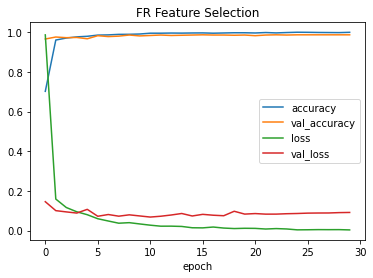

In [237]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [238]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [239]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [240]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.09141267836093903
Test accuracy: 0.9866666793823242
accuracy: 98.67%


# ConvNN(RF) - top 500

## Train/Test split    

In [241]:
# from keras.utils import to_categorical
# outcome = encode(outcome['Project_id'])

In [242]:
#feature_sort_selected = feature_sort[feature_sort['importance'] > 0.0005]
feature_sort_selected = feature_sort.iloc[:500,:]
feature_sort_selected

,name,importance
195,NOX1,0.004088
5677,PAX8,0.003668
29198,RPL23AP12,0.003441
12812,EMX2,0.003314
57991,FP671120.7,0.003204
...,...,...
17682,ADH4,0.000648
52233,MTRNR2L12,0.000648
35308,KIFC1,0.000647
667,NEDD4L,0.000646


In [243]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [244]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [245]:
X_train

,NOX1,PAX8,RPL23AP12,EMX2,FP671120.7,SOX17,RP11-53M11.5,AC012123.1,DAPK2,NKX2-1-AS1,TMEFF2,LINC00483,F13B,NLGN3,SLC45A3,CSTA,PCA3,HNF1A,RP4-797C5.2,TPO,OVOL2,KLHL14,RP11-1151B14.3,NKX2-1,CTD-2182N23.1,TCERG1L,DNAJC18,CBLC,AHSG,CLRN3,LMX1B,SAA4,RP11-400N9.1,SFTPB,AP001187.9,CPNE4,MGAT4C,VSTM4,RP11-328L11.1,GPM6B,...,RP11-2K6.1,RP11-252A24.5,BCL2L15,SEMA5B,HMGN2P5,CDX2,RAB36,CTC-470C15.1,SCGB2A2,DPYS,ADH6,GPRC5A,LURAP1,ATOH1,FABP1,DUOX2,KPNA2,TMEM171,VCAM1,GABRB2,NR1I2,TM4SF5,LINC01485,POU5F1,CYP4A22,CDCA8,pRNA.2,RP11-191G24.1,RWDD2A,SLC17A3,CLCA2,GBP6,C5orf52,TRAIP,METTL9,ADH4,MTRNR2L12,KIFC1,NEDD4L,VIL1
78,0.000000,2.046322,0.794178,1.957351,3.122111,2.291502,0.776733,0.901882,0.116359,0.000000,0.0,0.000000,0.0,0.000000,0.523852,1.493591,0.0,0.000000,1.249566,0.000000,1.408370,1.251182,0.0,0.000000,0.000000,0.000000,0.352674,1.110404,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.242874,1.053398,0.895281,...,1.374064,0.000000,0.343755,0.527972,1.633383,0.000000,0.614642,0.208968,0.572644,0.000000,0.000000,1.158797,0.000000,0.000000,0.000000,0.000000,2.225101,0.318646,1.027233,0.000000,0.000000,0.000000,0.000000,0.522333,0.000000,1.461869,1.538930,0.000000,0.826579,0.000000,0.000000,0.000000,0.000000,0.607254,1.311971,0.0000,1.713418,1.450180,0.537807,0.000000
1425,0.000000,1.519381,0.000000,1.290081,0.000000,0.729324,0.000000,0.000000,0.308121,0.000000,0.0,0.000000,0.0,0.000000,0.797717,0.852468,0.0,1.391757,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.876262,0.000000,0.000000,2.194229,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.094152,0.000000,0.000000,...,0.000000,0.743569,0.000000,2.107881,0.801760,0.000000,1.229750,0.000000,0.000000,1.517335,0.000000,0.187898,0.465417,0.000000,0.901799,0.000000,1.600679,1.718251,2.298061,0.000000,0.000000,1.863427,0.088734,0.937790,0.000000,0.910185,0.000000,0.000000,1.018862,1.397257,0.000000,0.000000,0.000000,0.147907,1.805123,0.0000,0.774497,0.751472,1.207278,1.054373
2725,0.089069,0.758653,0.000000,0.000000,0.000000,0.459506,0.000000,0.000000,0.116309,0.000000,0.0,0.000000,0.0,0.000000,1.277986,2.166232,0.0,0.000000,0.000000,0.000000,1.102257,0.000000,0.0,0.000000,0.000000,0.000000,0.289504,2.228620,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.698991,0.000000,0.981567,...,0.000000,0.000000,0.050614,0.000000,0.618606,0.000000,0.245276,0.000000,0.000000,0.000000,0.000000,2.048797,0.000000,0.000000,0.000000,0.000000,2.539395,0.910053,0.649470,0.000000,0.000000,0.000000,0.000000,0.173804,0.000000,1.987936,0.000000,0.000000,0.688400,0.000000,2.601293,1.258387,0.000000,0.968262,1.391149,0.0000,0.408452,1.859503,1.300319,0.535792
3076,0.070160,2.512828,0.000000,0.000000,0.000000,0.771178,0.000000,0.671569,2.126678,1.309341,0.0,0.000000,0.0,0.000000,0.328275,0.818809,0.0,0.000000,0.000000,1.597929,0.971662,1.400028,0.0,2.409727,2.352351,2.036899,0.943629,0.000000,0.000000,0.163872,0.0,0.0,0.0,3.172443,0.000000,0.629709,1.154487,2.016141,0.000000,0.092482,...,0.000000,0.000000,0.000000,0.572584,0.851310,0.000000,1.606985,0.000000,0.000000,0.000000,0.000000,2.336307,1.204370,0.000000,0.000000,1.945417,1.557946,1.060936,0.773743,1.954527,0.000000,0.000000,0.000000,0.000000,0.000000,0.603467,0.000000,0.000000,0.890228,0.000000,0.219480,0.000000,0.000000,0.358689,1.919256,0.0000,0.499975,0.598415,1.270065,0.000000
2536,0.000616,0.000000,0.000000,0.000000,0.000000,0.556067,0.000000,0.000000,0.814388,0.000000,0.0,0.000000,0.0,0.000000,0.335315,0.000000,0.0,0.000000,0.071343,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.389432,0.000000,0.583837,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.261321,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.154690,0.000000,0.000000,0.272394,0.000000,0.000000,0.000000,0.000000,0.235171,0.000000,0.000000,0.062897,0.000000,0.972453,0.000000,1.192849,0.000000,0.000000,0.000000,0.798295,0.000000,0.000000,0.026556,0.000000,0.000000,0.111056,0.000000,0.328440,0.000000,0

## CONV1D 

In [246]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=13
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [247]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [248]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(13))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 481, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 481, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 481, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 472, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 472, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 47, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6016)              0

In [249]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [250]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [251]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
135/135 [==============================] - 19s 136ms/step - loss: 1.9943 - acc: 0.3241 - val_loss: 0.1060 - val_acc: 0.9733

Epoch 00001: val_loss improved from inf to 0.10597, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 2/30
135/135 [==============================] - 19s 140ms/step - loss: 0.1998 - acc: 0.9465 - val_loss: 0.0528 - val_acc: 0.9856

Epoch 00002: val_loss improved from 0.10597 to 0.05277, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 3/30
135/135 [==============================] - 20s 147ms/step - loss: 0.1201 - acc: 0.9640 - val_loss: 0.0500 - val_acc: 0.9878

Epoch 00003: val_loss improved from 0.05277 to 0.05001, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 4/30
135/135 [==============================] - 19s 142ms/step - loss: 0.0779 - acc: 0.9802 - val_loss: 0.0462 - val_acc: 0.9867

Epoch 00004: val_loss improved from 0.05001 to 0.04624,

In [252]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.056087251752614975
Test accuracy: 0.9911110997200012


Text(0.5, 0, 'epoch')

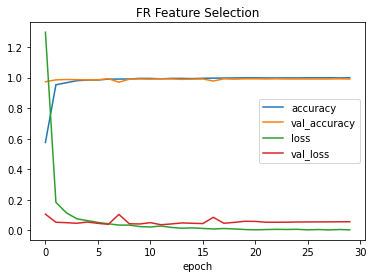

In [253]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [254]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [255]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [256]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.056087251752614975
Test accuracy: 0.9911110997200012
accuracy: 99.11%


# ConvNN(RF) - top 300

## Train/Test split    

In [257]:
# from keras.utils import to_categorical
# outcome = encode(outcome['Project_id'])

In [258]:
feature_sort_selected = feature_sort.iloc[:300,:]
feature_sort_selected

,name,importance
195,NOX1,0.004088
5677,PAX8,0.003668
29198,RPL23AP12,0.003441
12812,EMX2,0.003314
57991,FP671120.7,0.003204
...,...,...
8180,NFIC,0.000809
44307,RP11-357K6.1,0.000809
34576,ZNF853,0.000808
28790,LINC01320,0.000805


In [259]:
TC1data15_selected = TC1data15.loc[:,feature_sort_selected['name']]

In [260]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [261]:
X_train

,NOX1,PAX8,RPL23AP12,EMX2,FP671120.7,SOX17,RP11-53M11.5,AC012123.1,DAPK2,NKX2-1-AS1,TMEFF2,LINC00483,F13B,NLGN3,SLC45A3,CSTA,PCA3,HNF1A,RP4-797C5.2,TPO,OVOL2,KLHL14,RP11-1151B14.3,NKX2-1,CTD-2182N23.1,TCERG1L,DNAJC18,CBLC,AHSG,CLRN3,LMX1B,SAA4,RP11-400N9.1,SFTPB,AP001187.9,CPNE4,MGAT4C,VSTM4,RP11-328L11.1,GPM6B,...,LHFPL4,PCDHGC4,FOXN1,FAM168A,TNRC18P1,SCG3,RP13-514E23.1,RP11-115H13.1,SCN3A,U47924.27,ISCU,SH3BGRL2,SCHIP1,SFTA1P,MOGAT3,SYT11,TM4SF4,NRXN1,APCS,ESRP1,FYN,F10,CNRIP1,ETV4,HNF1B,ATCAY,BIK,AC034228.3,ZBTB47,TFR2,TMEM40,CYP2D6,CACNB3,LINC00634,FXYD2,NFIC,RP11-357K6.1,ZNF853,LINC01320,HILPDA
78,0.000000,2.046322,0.794178,1.957351,3.122111,2.291502,0.776733,0.901882,0.116359,0.000000,0.0,0.000000,0.0,0.000000,0.523852,1.493591,0.0,0.000000,1.249566,0.000000,1.408370,1.251182,0.0,0.000000,0.000000,0.000000,0.352674,1.110404,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.242874,1.053398,0.895281,...,0.0,0.0,0.000000,1.288315,0.0,0.0,0.000000,0.000000,0.000000,1.762018,1.687619,1.151277,0.000000,0.000000,0.000000,0.719523,0.000000,0.0,0.000000,1.744177,1.109324,0.224894,0.832869,1.260198,0.000000,0.0,1.268097,0.0,1.010122,0.000000,0.000000,0.204500,0.719330,0.000000,0.000000,1.797812,0.0,0.977710,0.072577,1.037945
1425,0.000000,1.519381,0.000000,1.290081,0.000000,0.729324,0.000000,0.000000,0.308121,0.000000,0.0,0.000000,0.0,0.000000,0.797717,0.852468,0.0,1.391757,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.876262,0.000000,0.000000,2.194229,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.094152,0.000000,0.000000,...,0.0,0.0,0.000000,1.481683,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.884528,1.707599,0.000000,0.000000,0.547267,1.260667,0.000000,0.0,0.324557,0.000000,1.218239,1.406566,0.670603,0.000000,1.890947,0.0,0.000000,0.0,0.920802,0.000000,0.000000,0.000000,0.714553,0.000000,1.941709,1.591891,0.0,0.253733,1.943943,2.684109
2725,0.089069,0.758653,0.000000,0.000000,0.000000,0.459506,0.000000,0.000000,0.116309,0.000000,0.0,0.000000,0.0,0.000000,1.277986,2.166232,0.0,0.000000,0.000000,0.000000,1.102257,0.000000,0.0,0.000000,0.000000,0.000000,0.289504,2.228620,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.698991,0.000000,0.981567,...,0.0,0.0,1.283457,1.397853,0.0,0.0,0.000000,0.000000,0.000000,1.135037,1.767718,0.652350,0.000000,0.225787,0.000000,0.857401,0.000000,0.0,0.000000,2.024956,1.033567,0.000000,0.634271,1.527647,0.061321,0.0,1.374414,0.0,1.049054,0.000000,0.698537,0.120485,1.083792,0.000000,0.000000,1.266841,0.0,0.582462,0.000000,1.420515
3076,0.070160,2.512828,0.000000,0.000000,0.000000,0.771178,0.000000,0.671569,2.126678,1.309341,0.0,0.000000,0.0,0.000000,0.328275,0.818809,0.0,0.000000,0.000000,1.597929,0.971662,1.400028,0.0,2.409727,2.352351,2.036899,0.943629,0.000000,0.000000,0.163872,0.0,0.0,0.0,3.172443,0.000000,0.629709,1.154487,2.016141,0.000000,0.092482,...,0.0,0.0,0.000000,1.733352,0.0,0.0,0.000000,0.000000,0.000000,1.628011,2.211016,2.343724,0.000000,0.783002,0.000000,0.981627,0.717146,0.0,0.000000,1.839214,1.946826,0.000000,0.558493,1.716899,0.000000,0.0,0.769110,0.0,1.629641,0.000000,0.206418,0.000000,1.056463,0.000000,0.000000,1.844430,0.0,1.391419,0.000000,1.089142
2536,0.000616,0.000000,0.000000,0.000000,0.000000,0.556067,0.000000,0.000000,0.814388,0.000000,0.0,0.000000,0.0,0.000000,0.335315,0.000000,0.0,0.000000,0.071343,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.389432,0.000000,0.583837,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.261321,0.000000,0.000000,...,0.0,0.0,0.000000,0.944180,0.0,0.0,0.000000,0.000000,0.107829,0.000000,1.725187,1.149893,0.000000,0.724794,0.000000,0.000000,0.000000,0.0,0.452466,0.000000,0.840601,3.160822,1.042127,0.000000,0.000000,0.0,0.000000,0.0,1.592777,0.000000,0.000000,0.000000,0.313864,0.000000,0.000000,1.749892,0.0,0.081274,0.000000,1.854278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

## CONV1D 

In [262]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=13
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [263]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [264]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(13))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 281, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 281, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 281, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 272, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 272, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0

In [265]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_rf'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [266]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [267]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
135/135 [==============================] - 12s 87ms/step - loss: 1.6988 - acc: 0.4509 - val_loss: 0.0961 - val_acc: 0.9733

Epoch 00001: val_loss improved from inf to 0.09607, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 2/30
135/135 [==============================] - 12s 85ms/step - loss: 0.1908 - acc: 0.9494 - val_loss: 0.1251 - val_acc: 0.9678

Epoch 00002: val_loss did not improve from 0.09607
Epoch 3/30
135/135 [==============================] - 11s 84ms/step - loss: 0.1153 - acc: 0.9650 - val_loss: 0.0623 - val_acc: 0.9833

Epoch 00003: val_loss improved from 0.09607 to 0.06229, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_rf.autosave.model.h5
Epoch 4/30
135/135 [==============================] - 11s 84ms/step - loss: 0.0826 - acc: 0.9757 - val_loss: 0.0671 - val_acc: 0.9811

Epoch 00004: val_loss did not improve from 0.06229
Epoch 5/30
135/135 [==============================] - 11s 85ms/step - loss: 0.0767 - acc: 0.

In [268]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.07264737784862518
Test accuracy: 0.9900000095367432


Text(0.5, 0, 'epoch')

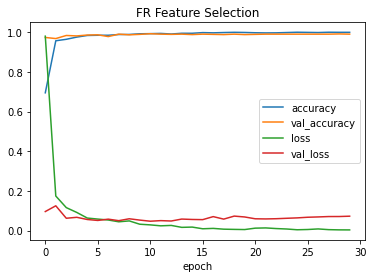

In [269]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [270]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [271]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [272]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.07264737784862518
Test accuracy: 0.9900000095367432
accuracy: 99.00%
